# Locally Linear Embedding
This is the fourth part in *Manifold Learning: Introduction and Foundational Algorithms*, and the entire project can be viewed at https://github.com/drewwilimitis/Manifold-Learning <br>
<br>
`Drew Wilimitis`

Locally Linear Embedding（LLE）是一种直观的方法，基于这样一个观点：足够小的邻域将代表沿着流形的局部区域，并且这些区域将近似为线性。通过沿着流形进行局部拟合，并学习数据固有结构定义的关系，LLE可以学习全局的、非线性的流形几何结构。 <br>
<br>
LLE方法的理念在于我们用局部线性关系来定义数据点。我们将数据点$x_i$定义为其局部邻居的线性组合，然后找到一个保留这些局部线性关系的低维嵌入。

![lle](https://user-images.githubusercontent.com/16658498/56095416-5c6ef800-5ea2-11e9-8ce0-5da013aee4e8.gif)<br>

**figure source**: S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*

### 算法概述（局部线性嵌入）：

**输入：** 具有参数 k（最近邻）和 m（嵌入维度）的数据向量 $\mathbf{x_1}, ..., \mathbf{x_n} \in \mathbb{R^d}$ <br>
**输出：** 低维嵌入向量 $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$，其中 $m < d$<br>

**步骤**：<br>
1. 为每个 $x_i$ 找到 $k$ 个最近邻<br>
2. 解出权重 $W$，以将每个 $x_i$ 重构为邻居的线性组合<br>
3. 解出保留局部线性关系的低维嵌入坐标 $y_i \in \mathbb{R}^m$

### 步骤 1：找到 k最近邻

首先，必须定义参数 k，以指定我们用于线性建模每个 $x_i$的最近邻数量。在应用算法之前，没有保证的方法来确定 k 的最佳值，不同的 k 值通常会极大地影响 LLE 的性能。在深入算法细节之前，下面使用  `sklearn.manifold` 库中的 LLE 展示了局部线性嵌入如何随 k 值的变化而变化的示例。

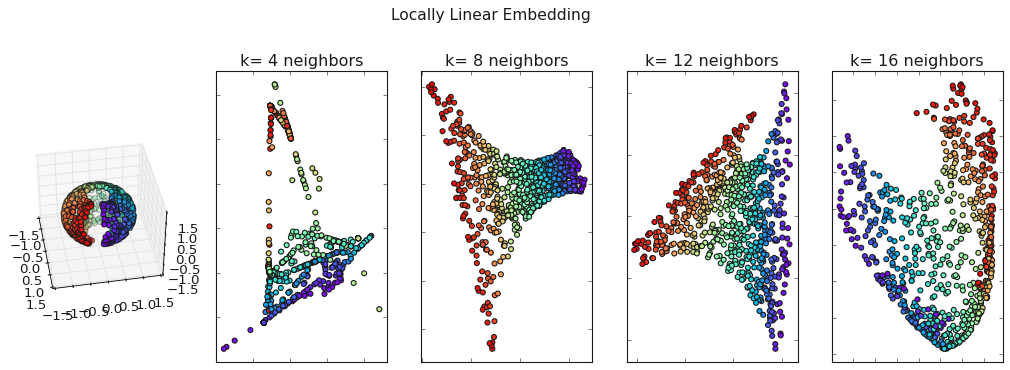

In [388]:
# 导入所需的库和模块
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图工具
from matplotlib.ticker import NullFormatter  # 导入NullFormatter用于设置坐标轴标签
from sklearn import manifold  # 导入流形学习模块
from sklearn.utils import check_random_state  # 导入用于检查随机状态的工具
%matplotlib inline 
# 在一个cell中显示多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
plt.style.use('classic')  # 设置matplotlib样式为经典风格
plt.rcParams['figure.facecolor'] = 'white'  # 设置图形背景颜色为白色

n_samples = 1000  # 样本数量

# 创建球体
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# 从球体上去掉极点
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# 绘制数据集
fig = plt.figure(figsize=(16, 10))
plt.suptitle("Locally Linear Embedding", fontsize=14)  # 设置标题

ax = fig.add_subplot(251, projection='3d')  # 添加3D子图
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)  # 绘制散点图
ax.view_init(40, -10)  # 设置视角

sphere_data = np.array([x, y, z]).T  # 创建球体数据矩阵

# 执行局部线性嵌入
neighbors = np.arange(4, 20, 4)  # 邻居节点数量范围

for i, neighbor in enumerate(neighbors):
    trans_data = manifold.LocallyLinearEmbedding(n_neighbors=neighbor, n_components=2).fit_transform(sphere_data).T  # 执行局部线性嵌入并转换数据维度
    ax = fig.add_subplot(252 + i)  # 添加子图
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)  # 绘制散点图
    ax.xaxis.set_major_formatter(NullFormatter())  # 设置x轴标签格式为空
    ax.yaxis.set_major_formatter(NullFormatter())  # 设置y轴标签格式为空
    plt.title('k= ' + str(neighbor) + ' neighbors')  # 设置子图标题
    plt.axis('tight')  # 自适应坐标轴范围
plt.show();  # 显示图形

似乎最佳的 k 值在中间大约是 8 到 12 之间。当使用较低的 k 值时，线性组合中没有足够的邻居点来准确传达流形的结构。对于非常高的 k 值，邻域开始扩展以包括过多的全局球形结构，导致的嵌入变得更加弯曲。

## 步骤 2: 线性组合和最优权重

在找到最近邻之后，我们根据邻域内的局部线性关系来定义数据点 $x_i$。对于每个维度为 $d$ 的 $x_i$，我们使用其 k 个最近邻的线性组合来重构 $x_i$。
**注意**：这种线性组合重构也是在维度 $d$ 上进行的。
对于每个点 $x_i$，我们定义一个线性组合，使用权重系数矩阵 $W \in \mathbb{R}^{k \times n}$ 来确定每个最近邻 $x_j$ 的贡献。对于权重矩阵 $W$，我们有

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1k} \\
w_{21} & w_{22} & \cdots & w_{2k} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nk}
\end{bmatrix}$$

对于某些 $x_i$，我们有如下线性组合

$$\sum_{j=1}^{k} w_{ij} x_j = w_{i1} x_{1} + \cdots + w_{ik} x_{k}$$

由于我们希望准确重构 $x_i$ 作为线性组合，我们通过以下成本函数来定义总重构误差：

$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2$$

这具有残差平方和的形式，其中误差是原始 $x_i$ 和我们的最近邻构造之间的欧氏距离。成本函数是权重的函数，因为数据 $x_i$ 已知，所以通过找到具有最低重构误差的最优权重来最小化此成本函数。


**对于旋转、缩放、平移的不变性:**

根据我们定义的成本函数，最优权重对于旋转、缩放和平移是不变的，因此它们反映了原始数据的内在几何特性，因为可以想象应用这些欧几里得变换之一，而局部线性关系仍然保持不变。

### 使用受限最小二乘法找到权重

最优权重是使成本函数最小化的权重：
$$\mathcal{E}(W) = \sum_{i} ||x_i - \sum_{j} w_{ij} x_j||^2$$
受到以下约束：
- 权重矩阵的行之和为一：$\sum_{j} w_{ij} = 1$

考虑特定的 $x_i$ 的误差：
$$
\begin{equation}
\begin{aligned}
\\ \mathcal{E}_i & = ||x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||(w_{i1} + \cdots + w_{ik}) x_i - \sum_{j} w_{ij} x_j||^2 & \text{(权重之和 = 1)}\\
            & = ||\sum_{j} w_{ij}x_i - \sum_{j} w_{ij} x_j||^2\\
            & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
\end{aligned}
\end{equation}$$


现在，设 $z_j = x_i - x_j$，并且 $\mathbf{z}$ 是 k x d 矩阵，其中行是 $\mathbb{R}^d$ 中的向量：
$$\mathbf{z} = \begin{bmatrix}
z_{1} = x_{i} - x_{1} \\
z_{2} = x_{i} - x_{2} \\
\vdots \\
z_{k} = x_{i} - x_{k} 
\end{bmatrix}$$

并且 $w_i$ 是 k x 1 向量，包含 $x_i$ 每个邻居的权重：
$$\mathbf{w_i} = \begin{bmatrix}
w_{i1} \\
w_{i2} \\
\vdots \\
w_{ik}  
\end{bmatrix}$$

我们可以重写损耗函数: <br>
$$
\begin{equation}
\begin{aligned}
\mathcal{E}_i & = ||\sum_{j} w_{ij} (x_i - x_j)||^2\\
            & = ||\sum_{j} w_{ij} z_j||^2\\
            & = ||w_{i1} z_1 + ... + w_{ik} z_k||^2\\
\\
            & = ||w_{i}^{T} z||^2\\
\\
            & = w_{i}^{T} z (w_{i}^{T} z)^{T}\\
\\
            & = w_{i}^{T} z z^{T} w_{i}\\
\end{aligned}
\end{equation}
$$

**注意**：倒数第二行由于对于一个 1 x d 行向量 $\mathbf{r}$，有 $||\mathbf{r}||^2 = \mathbf{r} \mathbf{r}^T$，而 $w_{i}^{T} z$ 是一个 1 x d 行向量。

$zz^{T}$ 是以 $x_i$ 为中心的局部协方差或 **Gram 矩阵**，我们用 $G_i$ 表示。Gram 矩阵是一个对称的、半正定的 k x k 矩阵，包含了 $x_i$ 的局部邻域的内积。
$$G_{jk} = (x_i-x_j) \cdot (x_i - x_k)$$


$$\mathbf{G_i} = \begin{bmatrix}
(x_i-x_1) \cdot (x_i - x_1) & (x_i-x_1) \cdot (x_i - x_2) & \cdots & (x_i-x_1) \cdot (x_i - x_k) \\
(x_i-x_2) \cdot (x_i - x_1) & (x_i-x_2) \cdot (x_i - x_2) & \cdots & (x_i-x_2) \cdot (x_i - x_k) \\
\vdots & \vdots & \vdots & \vdots \\
(x_i-x_k) \cdot (x_i - x_1) & (x_i-x_k) \cdot (x_i - x_2) & \cdots & (x_i-x_k) \cdot (x_i - x_k)
\end{bmatrix}$$

我们得到成本函数的最终形式：

$$\mathcal{E}_i = w_{i}^{T} G_i w_{i}$$

**拉格朗日乘子问题**

我们令 $\mathbf{1}$ 为所有元素均为 1 的 k x 1 矩阵，所以

$$\mathbf{1}^T w_i = 1$$

表示我们的约束条件，即权重之和为 1。

我们对其进行偏导并置零：

$$\mathcal{L}(w_i, \lambda) = w_{i}^{T} G_i w_{i} - \lambda(\mathbf{1}^T w_i - 1) = 0$$

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} = 0 \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1} = 0
\end{equation}

根据第一个偏导数得到：

$$2G_i w_i = \lambda \mathbf{1} $$

如果 $G_i$ 可逆，我们有一个闭式形式来计算最优权重：

$$\boxed {w_i = \frac{\lambda}{2} G_{i}^{-1} \mathbf{1}}$$

其中 $\lambda$ 可以被选择以确保所有值之和为 1。


为了避免找到显式的逆矩阵，在实践中通常更容易解线性方程组，其形式为：

$$\boxed{G_{i} \mathbf{w_{i}} = \mathbf{1}}$$

其中每个 k 个方程的形式为：

$$\sum_{k} G_{j k} w_{ik}=1$$

最后我们重新调整权重，使它们之和为 1。

**注意:** 我们分别为每个点找到最优权重。

### <font color='blue'> 例子 - 局部线性组合 </font>

为了找到给定数据的最佳权重，我们使用了 `sklearn.manifold` 中LLE的以下两个函数，可以在此处查看：https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/locally_linear.py 

In [389]:
from scipy.linalg import solve  # 导入 solve 函数
def barycenter_weights(X, Z, reg=1e-3):
    """计算X的重心权重，使其从Y沿第一轴进行估计
    我们估计每个Y[i]点分配给X[i]的权重。重心权重之和为1。
    参数
    ----------
    X : 类数组，形状为 (n_samples, n_dim)
    Z : 类数组，形状为 (n_samples, n_neighbors, n_dim)
    reg : 浮点数，可选
        正则化的数量，以使问题在 n_neighbors > n_dim 的情况下适当
    返回
    -------
    B : 类数组，形状为 (n_samples, n_neighbors)
    """
    n_samples, n_neighbors = X.shape[0], Z.shape[1]  # 获取样本数量和邻居数
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)  # 创建一个存储权重的数组
    v = np.ones(n_neighbors, dtype=X.dtype)  # 创建一个值为1的数组，与邻居数相同

    # 如果G是奇异矩阵且迹为零，这可能引发LinalgError
    for i, A in enumerate(Z.transpose(0, 2, 1)):  # 遍历Z的转置
        C = A.T - X[i]  # 计算C，广播操作
        G = np.dot(C, C.T)  # 计算G矩阵
        trace = np.trace(G)  # 计算G的迹
        if trace > 0:  # 如果迹大于0
            R = reg * trace  # 设置R为正则化乘以迹
        else:
            R = reg  # 否则，R为正则化
        # 将正则化项加到G的对角线
        G.flat[::Z.shape[1] + 1] += R
        # 解线性方程组 Gw=v
        w = solve(G, v) 
        # 重新调整权重
        B[i, :] = w / np.sum(w)
    return B  # 返回权重数组


In [390]:
from scipy.linalg import eigh, svd, qr, solve  # 导入函数
from scipy.sparse import eye, csr_matrix, find  # 导入函数
from scipy.sparse.linalg import eigsh  # 导入函数
from sklearn.neighbors import NearestNeighbors  # 导入函数

def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=None):
    """计算X中点的k近邻的重心加权图
    参数
    ----------
    X : {类数组, NearestNeighbors}
        样本数据，形状为 (n_samples, n_features)，可以是numpy数组或NearestNeighbors对象。
    n_neighbors : int
        每个样本的邻居数。
    reg : 浮点数，可选
        解最小二乘问题时的正则化量。仅在mode='barycenter'时相关。如果为None，则使用默认值。
    n_jobs : int 或 None，可选（默认为 None）
        用于邻居搜索的并行作业数。``None`` 表示 1，除非在 :obj:`joblib.parallel_backend` 上下文中。``-1`` 表示使用所有处理器。
        有关更多详细信息，请参阅 :term:`词汇表 <n_jobs>`。
    返回
    -------
    A : CSR格式的稀疏矩阵，形状为 [n_samples, n_samples]
        A[i, j] 被赋予连接 i 到 j 的边的权重。
    参见
    --------
    sklearn.neighbors.kneighbors_graph
    sklearn.neighbors.radius_neighbors_graph
    """
    knn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs).fit(X)  # 训练最近邻模型
    X = knn._fit_X  # 获取训练数据
    n_samples = X.shape[0]  # 获取样本数
    ind = knn.kneighbors(X, return_distance=False)[:, 1:]  # 获取邻居的索引
    data = barycenter_weights(X, X[ind], reg=reg)  # 计算重心权重
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)  # 获取indptr
    return csr_matrix((data.ravel(), ind.ravel(), indptr),  # 返回CSR格式稀疏矩阵
                      shape=(n_samples, n_samples))  # 返回稀疏矩阵的形状

In [391]:
from sklearn.metrics import pairwise_distances  # 导入函数

# 输出一个 N x k 的矩阵，其中每个观测值在 X 中有 k 个最近邻
def nearest_neighbors(X, k):
    # 这里我们使用 k+1，因为 Xi 会与自身具有最短的距离
    knn_matrix = np.zeros((len(X), k))  # 创建一个全零矩阵
    # 计算两两之间的距离
    dist_matrix = pairwise_distances(X)  # 计算特征矩阵 X 的两两距离
    # 对于每一行找出 k 个最近邻的索引
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]  # 对距离排序并取最近的 k 个邻居的索引
    return knn_matrix  # 返回最近邻矩阵


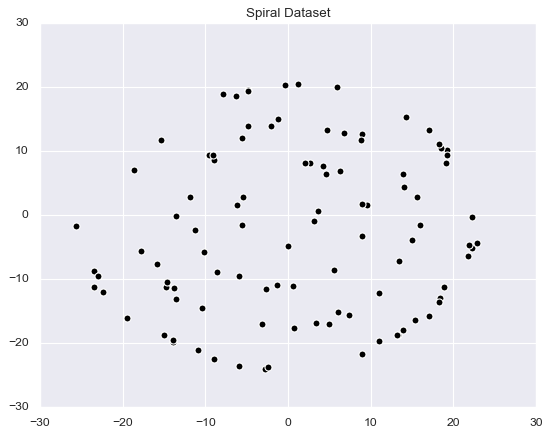

In [392]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()  # 设置 seaborn 默认格式

'''
# 生成螺旋数据集
n = 100  # 数据集大小
u = np.sqrt(np.random.rand(n,1)) * 1440 * (2*np.pi)/360  # 生成随机值 u
x = -np.cos(u)*u + np.random.randn(n,1)*0.5  # 计算 x 坐标
y = np.sin(u)*u + np.random.randn(n,1)*0.5  # 计算 y 坐标
X = np.hstack((x,y))  # 合并 x 和 y 到 X
# 将数据集保存为文本文件（CSV格式）
np.savetxt('spiral_dataset.csv', X, delimiter=',')
'''

# 加载保存的数据集
X = np.loadtxt('D:/OneDrive - email.szu.edu.cn/Manifold Learning/Locally linear embedding/spiral_dataset.csv', delimiter=',')
# 将第一列数据分配给 x，第二列数据分配给 y
x = X[:, 0]
y = X[:, 1]

# 绘制散点图
plt.scatter(x, y, c='black', s=40)  # 绘制散点图，用黑色表示数据点，设置点的大小为 40
plt.title('Spiral Dataset')  # 设置图标题为 'Spiral Dataset'
plt.show();  # 展示图形


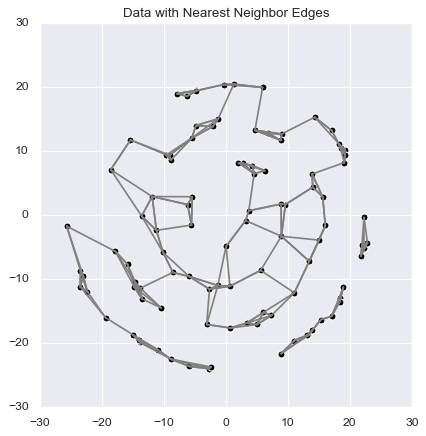

In [393]:
# 遍历每个数据点并绘制到最近邻的连线
plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40)  # 绘制散点图，alpha 为不透明度，用黑色表示数据点，点的大小为 40
k = 3  # 设置最近邻的数量为 3
neighbors = nearest_neighbors(X, k).astype('int')  # 找到每个数据点的最近邻索引，返回整数数组

# 循环遍历每个数据点
for i in range(len(X)):
    knn = neighbors[i]  # 获取第 i 个数据点的最近邻索引
    # 循环遍历每个最近邻
    for j in range(k):
        # 绘制连接当前点与其最近邻之间的灰色线段
        plt.plot(X[[i, knn[j]], 0], X[[i, knn[j]], 1], c='gray')  # 绘制当前点与最近邻之间的连线，颜色为灰色

plt.title('Data with Nearest Neighbor Edges');  # 设置图标题为 'Data with Nearest Neighbor Edges'

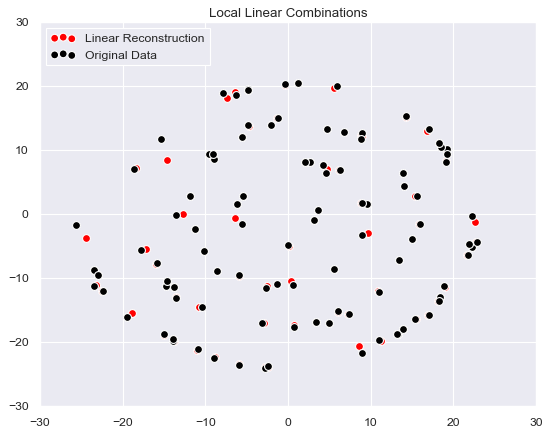

In [394]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph  # 导入需要的库

# 利用 barycenter_kneighbors_graph 函数计算权重矩阵 W
W = barycenter_kneighbors_graph(X, n_neighbors=k)  # 使用函数计算权重矩阵

linear_combos = []  # 初始化存储线性组合结果的列表
neighborhood_weights = []  # 初始化存储邻域权重的列表

# 循环遍历每个数据点
for i in range(len(X)):
    weights = W.toarray()[i][neighbors[i]]  # 获取当前点的权重
    neighborhood = X[neighbors[i]]  # 获取当前点的邻域数据点
    weighted_neighbors = weights.reshape(-1, 1) * neighborhood  # 计算加权邻域点
    lin_x1 = np.sum(weighted_neighbors[:, 0])  # 计算线性组合后的 x1 坐标
    lin_x2 = np.sum(weighted_neighbors[:, 1])  # 计算线性组合后的 x2 坐标
    linear_combos.append([lin_x1, lin_x2])  # 将线性组合的结果添加到列表中
    neighborhood_weights.append(weights)  # 将邻域权重添加到列表中

linear_X = np.array(linear_combos)  # 将线性组合的结果转换为 NumPy 数组
# 绘制散点图，用红色表示线性重构的数据点，用黑色表示原始数据点
plt.scatter(linear_X[:, 0], linear_X[:, 1], c='red', s=50, label='Linear Reconstruction')
plt.scatter(X[:, 0], X[:, 1], c='black', s=50, label='Original Data')
plt.title('Local Linear Combinations')  # 设置图标题为 'Local Linear Combinations'
plt.legend(loc='upper left');  # 设置图例位置在左上角

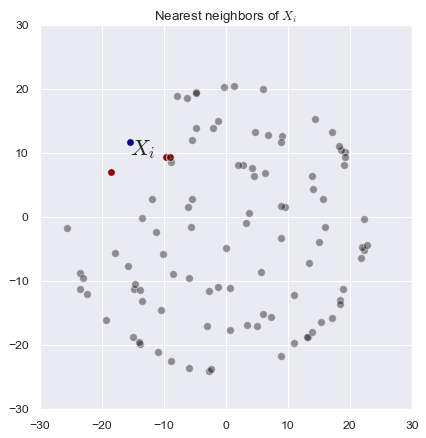

In [395]:
# 找到最大重构误差的 xi 的邻居点
ix = np.argmax([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])  # 找到最大重构误差的数据点索引
xi_neighbors = neighbors[ix]  # 获取该数据点的邻居点索引

plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(X[ix, 0], X[ix, 1], c='blue', s=50)  # 绘制最大重构误差的数据点，用蓝色表示
plt.text(X[ix, 0], X[ix, 1] - 2, s='$X_i$', size=20)  # 在该点的下方绘制 '$X_i$' 的文本标签

plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='red', s=50)  # 绘制该数据点的邻居点，用红色表示
plt.scatter(X[:, 0], X[:, 1], alpha=0.4, c='black', s=50)  # 绘制所有数据点，用黑色表示，设置透明度为0.4
plt.title('Nearest neighbors of $X_i$');  # 设置图标题为 'Nearest neighbors of $X_i$'

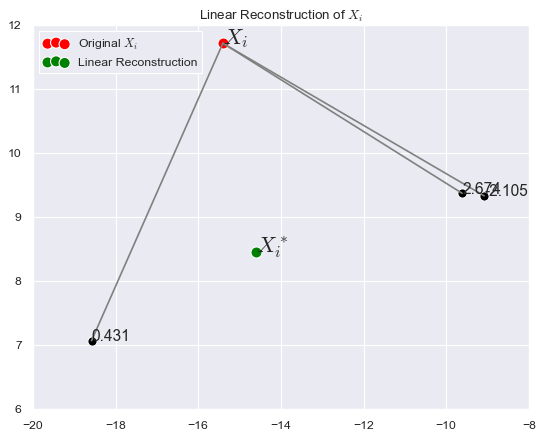

In [396]:
xi_weights = np.round(neighborhood_weights[ix], 3)  # 获取最大重构误差数据点的邻居点权重并保留三位小数

plt.scatter(X[ix, 0], X[ix, 1], c='red', s=100, alpha=1, label='Original $X_i$')  # 绘制最大重构误差的数据点，用红色表示
plt.text(X[ix, 0], X[ix, 1], s='$X_i$', size=20)  # 在最大重构误差数据点处绘制 '$X_i$' 的文本标签

plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='black', alpha=1, s=70)  # 绘制最大重构误差数据点的邻居点，用黑色表示
plt.scatter(linear_X[ix, 0], linear_X[ix, 1], c='green', s=100, label='Linear Reconstruction')  # 绘制线性重构后的数据点，用绿色表示
plt.text(linear_X[ix, 0], linear_X[ix, 1], s='$X_i^*$', size=20)  # 在线性重构数据点处绘制 '$X_i^*$' 的文本标签

# 遍历邻居点，并在图中显示其权重值
for i in range(len(xi_neighbors)):
    plt.text(X[xi_neighbors[i], 0], X[xi_neighbors[i], 1], s=str(xi_weights[i]), size=14)  # 在每个邻居点处绘制其权重值，大小为14
    plt.plot(X[[ix, xi_neighbors[i]], 0], X[[ix, xi_neighbors[i]], 1], c='gray')  # 绘制最大重构误差数据点与其邻居点之间的连线，用灰色表示

plt.title('Linear Reconstruction of $X_i$')  # 设置图标题为 'Linear Reconstruction of $X_i$'
plt.legend(loc='upper left');  # 在图的左上角显示图例

In [397]:
# 重构误差
np.linalg.norm(X[ix] - linear_X[ix]) #计算特定数据点 ix 的重构误差。
                                     #它使用 np.linalg.norm 函数计算原始数据点 X[ix] 与其对应的线性重构数据点 linear_X[ix] 之间的欧几里得距离。
np.sum([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))]) 
                                     #计算所有数据点的重构误差总和。它使用列表推导式迭代所有数据点，
                                     #并计算每个数据点 X[i] 与其对应的线性重构数据点 linear_X[i] 之间的欧氏距离，并将这些距离值求和以得到总体的重构误差。

3.353063514852921

23.20732408623781

## 步骤 3: 将数据映射到较低维度空间

我们现在构建从每个 $x_i \in \mathbb{R^d}$ 到其较低维度表示 $y_i \in \mathbb{R^m}$ 的映射。由于我们找到的最优权重具有某些不变性质，我们在这个映射中使用这些权重。我们定义了一个新的成本函数，与之前的形式类似，我们希望最小化重构误差：

$$\phi(Y) = \sum_{i} ||y_i - \sum_{j} w_{ij} y_j||^2$$

这一次，权重是固定的，我们通过以下约束条件找到最优坐标 $y_i$：
- $\sum_i y_i = 0$（以原点为中心，平移自由度）
- $\frac{1}{N} \sum_i y_i y_i^T = \mathbf{I}$（单位协方差，旋转自由度）


我们利用我们的约束条件重新编写成本函数：
 <br>

$$
\begin{aligned} 
\Phi(\mathbf{Y}) &=\sum_{i=1}^{n}\left(y_{i}-\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\sum_{i=1}^{n} y_{i}^{2}-y_{i}\left(\sum_{j} w_{i j} y_{j}\right)-\left(\sum_{j} w_{i j} y_{j}\right) y_{i}+\left(\sum_{j} w_{i j} y_{j}\right)^{2} \\
&=\mathbf{Y}^{T} \mathbf{Y}-\mathbf{Y}^{T}(\mathbf{w} \mathbf{Y})-(\mathbf{w} \mathbf{Y})^{T} \mathbf{Y}+(\mathbf{w} \mathbf{Y})^{T}(\mathbf{w} \mathbf{Y}) \\
&=(\mathbf{Y}^T-\mathbf{Y}^T\mathbf{w}^T)(\mathbf{Y}-\mathbf{w}\mathbf{Y}) \\
&=\mathbf{Y}^T(\mathbf{I}-\mathbf{w}^T)(\mathbf{I}-\mathbf{w})\mathbf{Y} \\
&=\mathbf{Y}^{T}(\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \mathbf{Y} \end{aligned}
$$

定义 m x m 矩阵 $M$:
$$
\begin{aligned} \mathbf{M} &= (\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \end{aligned}
$$

因此 $$\Phi(\mathbf{Y})=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}$$

我们设置一个拉格朗日乘子 $\mu$ 来施加约束 $n^{-1} \mathbf{Y}^{T} \mathbf{Y} = \mathbf{I}$ <br>
<br>
$$
\mathcal{L}(\mathbf{Y}, \mu)=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}-\mu\left(n^{-1} \mathbf{Y}^{T} \mathbf{Y}-1\right)
$$

$$
\begin{array}{c}{\frac{\partial \mathcal{L}}{\partial \mathbf{Y}}=2 \mathbf{M} \mathbf{Y}-2 \mu n^{-1} \mathbf{Y}=0} \\ {\mathbf{M Y}=\frac{\mu}{n} \mathbf{Y}}\end{array}
$$

根据最后一行，$Y$ 是 $M$ 的特征向量，为了最小化

$$\phi(Y) = Y^{T} M Y$$
 <br>
我们选择 $M$ 的最小的 m+1 个特征值（对应最小的特征值）作为我们的嵌入坐标，舍弃最小的特征向量-特征值对，因为根据我们构造的 $M$，第一个特征向量将是一个所有分量相等的单位向量。

### <font color='blue'> Example - Toy datasets</font>

我们首先将LLE应用于一个用于流形学习的合成数据集，以了解LLE算法如何学习复杂的非线性结构。

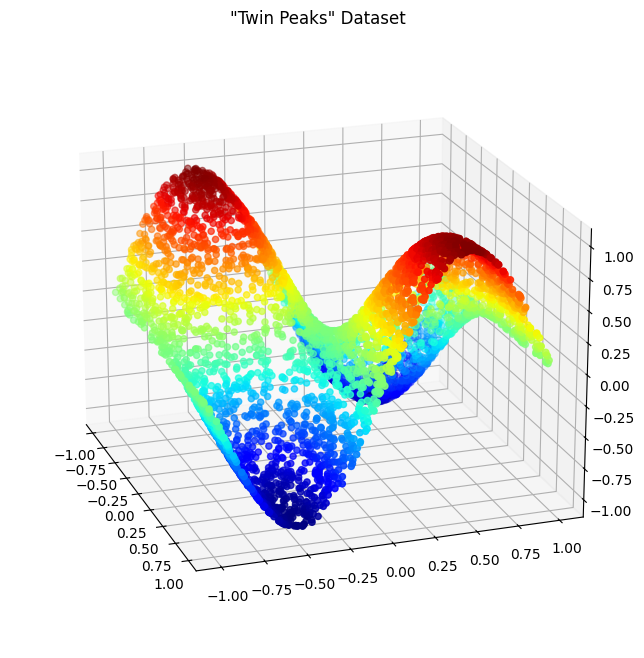

In [398]:
# twin peaks dataset
# 设置默认样式
plt.style.use('default')

# 设定数据集大小和参数
n = 5000
param = 1

# 生成随机数据
xy = 1 - 2 * np.random.rand(2, n)
p = np.array([xy[1, :], xy[0, :], param * np.sin(np.pi * xy[0, :]) * np.tanh(3 * xy[1, :])]).T

# 提取颜色信息
color = p[:, 2]

# 创建图表和子图
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=color, cmap=plt.cm.jet)

# 设置图表标题和视角
plt.title('"Twin Peaks" Dataset', size=12)
ax.view_init(20, -19);

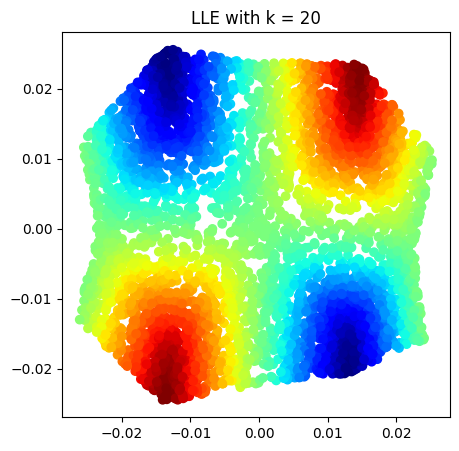

In [399]:
from sklearn.manifold import LocallyLinearEmbedding

# 创建 LocallyLinearEmbedding 实例
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20) 

# 对数据集进行降维处理
X_reduced = lle.fit_transform(p)

# 创建图表
fig = plt.figure(figsize=(5, 5))

# 设定图表标题
plt.title('LLE with k = 20', size=12)

# 绘制降维后的散点图
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet);

LLE 在这个高度非线性的数据集上表现相当不错。一般来说，二维的嵌入会将$\mathbb{R^3}$空间中的相邻实例放置在一起，而将远离的实例分开。原始“双峰”数据集中曲率最大的区域表示得不够好，这导致了不规则的、高密度的红色和蓝色区域。

另一个对流形学习和 LLE 有挑战性的合成数据集是以下构建的连接簇数据集。

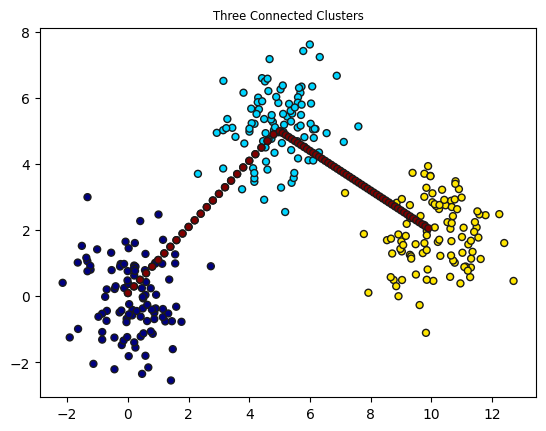

In [400]:
from sklearn.datasets import make_blobs  # 导入 make_blobs 函数，用于生成数据集
plt.title("Three Connected Clusters", fontsize='small')  # 设置图表标题为“Three Connected Clusters”，字体大小为小号
X1, Y1 = make_blobs(n_samples=300, n_features=2, centers=[[0,0], [5,5], [10,2]])  # 生成包含三个连接簇的数据集
t = np.arange(0, 1, 0.02)  # 创建一个范围在 0 到 1 之间的数组，步长为 0.02
l1 = np.array((t*5, t*5)).reshape(50, 2)  # 创建新的数据点形成一个线性簇 l1
l2 = np.hstack((np.array(5+5*t).reshape(-1,1), np.array(5+t*-3).reshape(-1,1)))  # 创建新的数据点形成另一个线性簇 l2
X = np.vstack((X1, l1, l2))  # 垂直堆叠原始数据集 X1 和线性簇 l1、l2，形成一个新的数据集 X
Y = np.vstack((Y1.reshape(-1,1), np.repeat(3, 100).reshape(-1,1)))  # 垂直堆叠原始标签 Y1 和新标签 3，形成新的标签 Y
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y.reshape(400,),  # 绘制散点图，以 X 的第一列和第二列作为坐标，Y 作为颜色标签
            s=25, edgecolor='k', cmap=plt.cm.jet);  # 设置散点的大小、边缘颜色、颜色映射为 jet

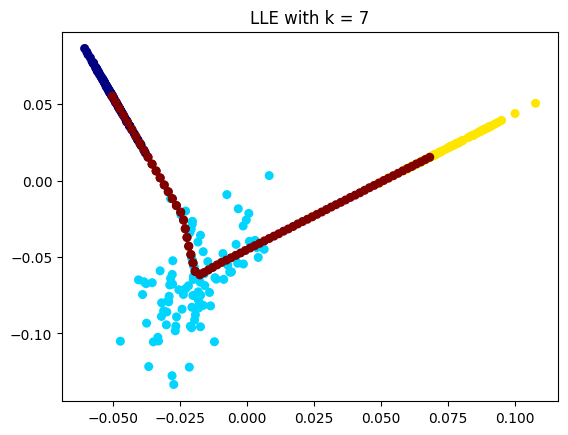

In [401]:
k = 7  # 设置 k 值为 7，即最近邻数
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=k)  # 初始化 LLE 模型，设置降维后的维度为 2，最近邻数为 k
X_reduced = lle.fit_transform(X)  # 对数据集 X 进行 LLE 降维处理，得到降维后的结果 X_reduced
plt.title('LLE with k = ' + str(k), size=12)  # 设置图表标题为 LLE with k = 7，字体大小为 12
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y.reshape(400,), s=30, cmap=plt.cm.jet);  # 绘制散点图，以 X_reduced 的第一列和第二列作为坐标，Y 作为颜色标签，设置点的大小为 30，颜色映射为 jet

LLE无法准确学习两个集群中的关系，在这个数据集上表现不佳。

### <font color='blue'> Example - Image Data</font>

In the final example, we apply LLE to one of the most common sources of high dimensional data - images. We load a sample image and display it using the `opencv-python`and the `matplotlib.image` libraries.

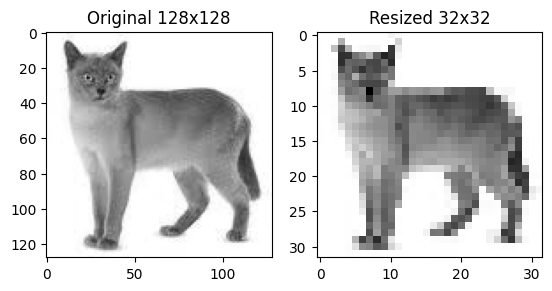

In [402]:
import cv2  # 导入OpenCV库
import matplotlib.image as img  # 导入Matplotlib库的图像模块
from skimage.color import rgb2gray  # 从Scikit-image库中的颜色模块导入rgb2gray函数
plt.style.use('default')  # 设置Matplotlib图表的默认样式

# 读取图像文件
image = cv2.imread("D:/OneDrive - email.szu.edu.cn/Manifold Learning/images/cat3.jpg")
# 将图像转换为灰度图像
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# 调整图像大小为32x32像素，使用双三次插值方法进行插值处理
res = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)

# 创建第一个子图，显示原始大小的灰度图像
plt.subplot(121)
plt.title('Original 128x128')
plt.imshow(image, cmap='gray')

# 创建第二个子图，显示调整大小后的32x32像素的灰度图像
plt.subplot(122)
plt.title('Resized 32x32')
plt.imshow(res, cmap='gray')

# 显示图像子图
plt.show();

调整大小后的图像是一个 32 x 32 = 1024 维的数组，其中的数值范围从 0 到 255，表示每个像素的强度。在压缩过程中存在一些明显的信息丢失。

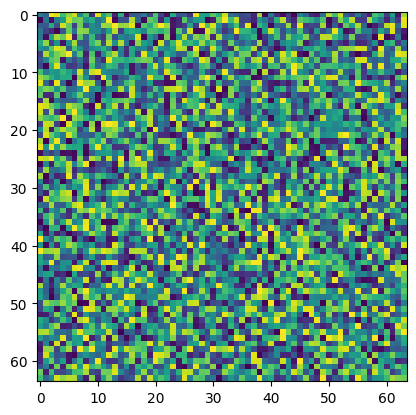

In [403]:
# 创建随机噪声图像
test_img = 255*np.random.rand(64, 64)
plt.imshow(test_img);

Next we create a set of images with our 32x32 cat image at various positions with the noise background.

In [404]:
# 创建一个列表用于存储位移后的图像
images = []

# 迭代生成位移后的图像
for i in range(33):
    for j in range(33):
        # 复制测试图像，使其成为临时变量
        tmp = np.copy(test_img)
        
        # 将猫的图像沿着背景滑动
        tmp[i:i+32, j:j+32] = res
        
        # 将生成的图像添加到列表中
        images.append(tmp)

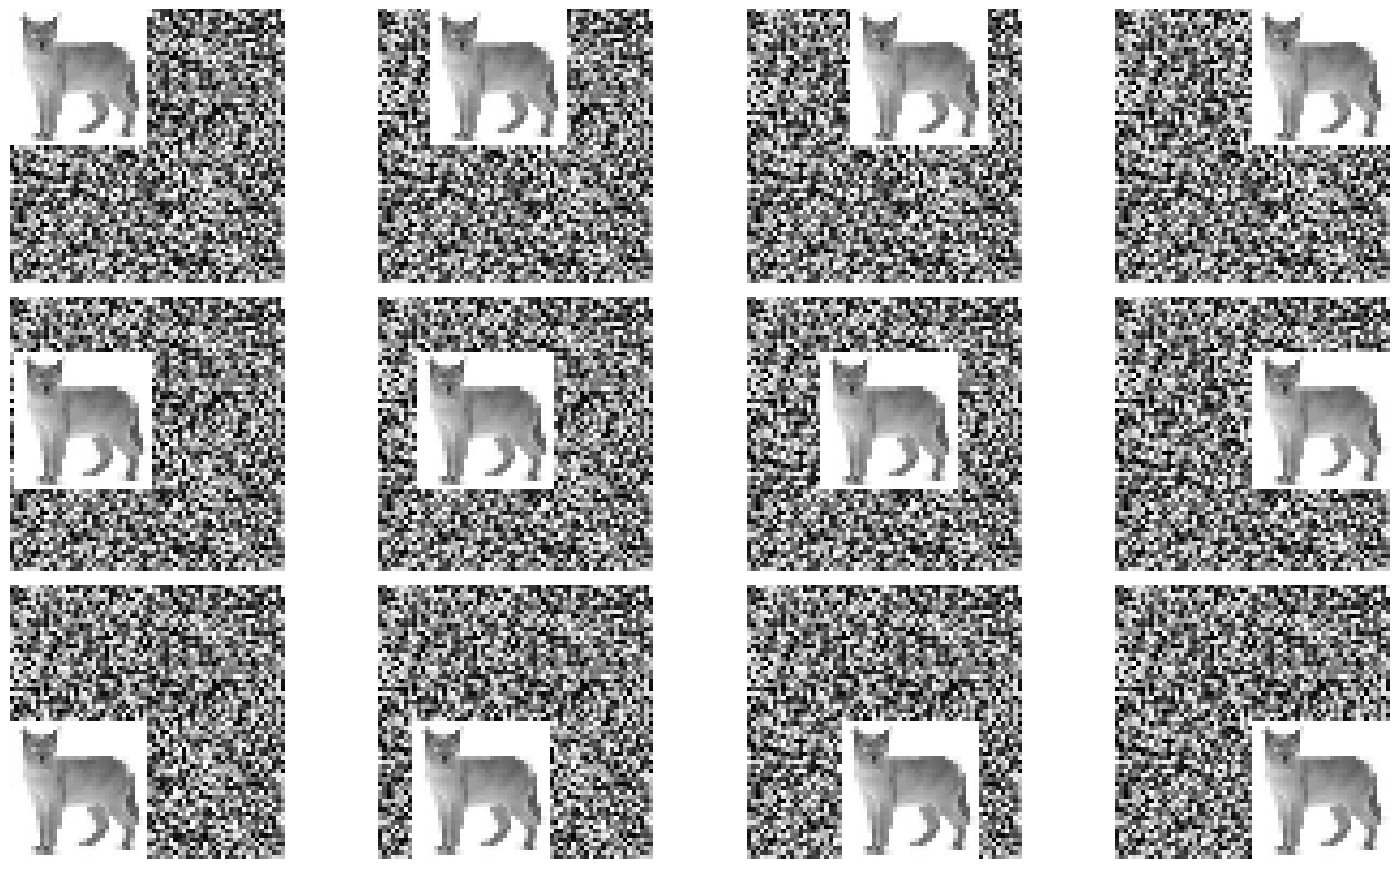

In [405]:
# 创建一个图形窗口
F = plt.figure(figsize=(15,10))

# 定义网格布局
G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.05, figure=F)

# 创建子图并显示一些生成的图像
ax = plt.subplot(G[0])
_ = ax.imshow(images[0], cmap='gray')

# 选择特定的图像索引
selected_images = [0, 12, 24, 32, 430, 438, 446, 461, 1056, 1064, 1078, 1088]

# 设置第一个子图的属性
ax.set_axis_off()
ax.set_aspect('equal')

# 在网格中绘制选定的图像
for i in range(1, 12):
    ax = plt.subplot(G[i])
    _ = ax.imshow(images[selected_images[i]], cmap='gray')
    ax.set_axis_off()
    ax.set_aspect('equal');

In [406]:
# get dimensions, number samples
np.array(images).shape
64*64

(1089, 64, 64)

4096

现在我们有 n=1089 个样本，外在维度为 64x64 = 4096。然而，内在维度实际上要低得多，因为真正的维度仅仅是移动图像的两个维度或者说 (x, y) 坐标。我们运用局部线性嵌入 (Locally Linear Embedding, LLE) 并将结果可视化为两个维度。

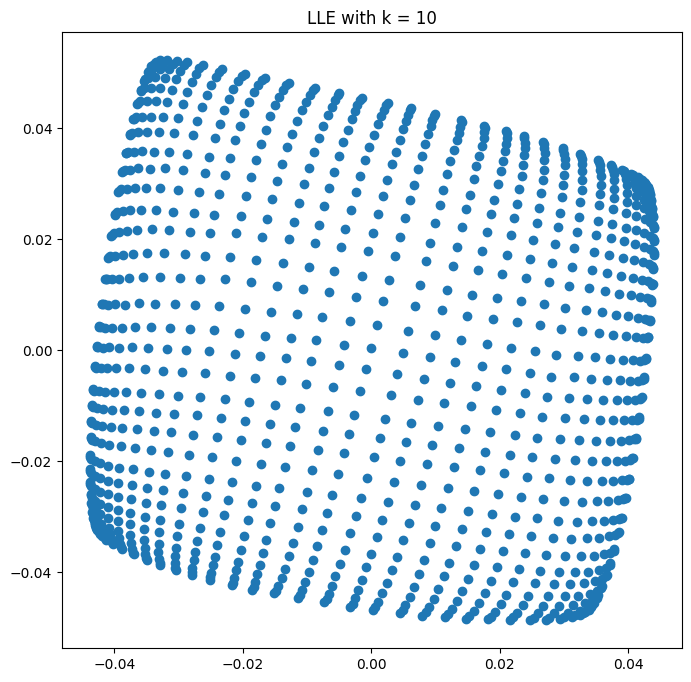

In [407]:
X = np.array(images).reshape(1089, 4096)  # 将图像数组重新整形为 1089 个样本，每个样本的维度为 4096
k = 10  # 设置 LLE 中的近邻数量
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=k)  # 使用 LLE 将数据降维到 2 维
X_reduced = lle.fit_transform(X)  # 对数据进行降维处理
fig = plt.figure(figsize=(8, 8))  # 创建图形窗口
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])  # 绘制降维后的数据散点图
plt.title('LLE with k = ' + str(k), size=12);  # 设置图表标题

In [408]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()  # 如果未指定坐标轴，则使用当前坐标轴
    
    proj = model.fit_transform(data)  # 对数据进行降维处理
    ax.plot(proj[:, 0], proj[:, 1], '.k')  # 绘制散点图
    
    if images is not None:  # 如果有图像数据
        # 计算最小距离
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 不显示距离太近的点
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            # 在散点图中添加图像
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=1),
                proj[i])
            ax.add_artist(imagebox)
        for i in selected_images:  # 针对选定的图像
            # 在散点图中添加图像
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap='gray'), 
                proj[i])
            ax.add_artist(imagebox)

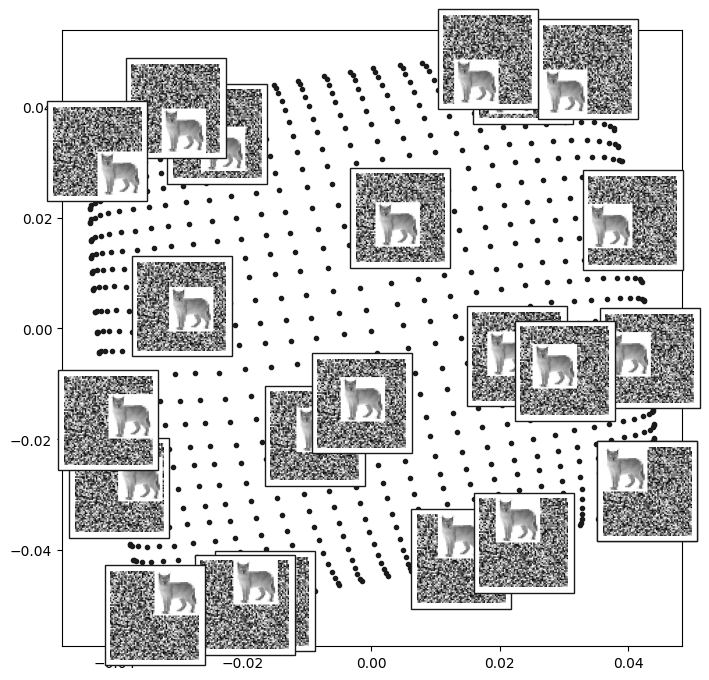

In [409]:
plt.figure(figsize=(8,8))  # 创建一个尺寸为 8x8 的图像

# 调用 plot_components 函数，将数据 X 经过 LocallyLinearEmbedding 转换成二维，并可视化显示
plot_components(X,
                model=LocallyLinearEmbedding(n_components=2, n_neighbors=k),  # 使用 LLE 模型降维到二维
                thumb_frac=0.3,  # 图像缩略比例
                images=images);   # 图像数据

LLE 能够很好地揭示内在结构并保留高维度关系，因此图像在二维平面上的位置与猫在图像中的位置非常相关，比如在这个二维表示中，猫的位置通常在图像的角落或中间。